# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

In [2]:
# pip install pyfinance

## Imports & Settings

In [7]:
# %matplotlib inline

import warnings
from datetime import datetime
import os
from pathlib import Path
import quandl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets
from pyfinance.ols import PandasRollingOLS
from sklearn.feature_selection import mutual_info_classif

In [8]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
idx = pd.IndexSlice

## Get Data

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [ ]:
# from quantrocket.history import create_usstock_db
# create_usstock_db("usstock-1d", bar_size="1 day")

In [2]:
# from quantrocket.history import collect_history
# collect_history("usstock-1d")

{'status': 'the historical data will be collected asynchronously'}

In [3]:
from quantrocket.master import get_securities
securities = get_securities(exchanges=["NASDAQ", "NYSE", "AMEX"], sec_types="STK", fields="*")
securities

/tmp/ipykernel_99826/442196122.py:2: DtypeWarning: Columns (26,27,28,29,30,31,32,33,35,36,38,39,40,41,42,43,44,45,46,47,49,50,51,52,54,55,56) have mixed types.Specify dtype option on import or set low_memory=False.
  securities = get_securities(exchanges=["NASDAQ", "NYSE", "AMEX"], sec_types="STK", fields="*")


,Symbol,Exchange,Country,Currency,SecType,Etf,Timezone,Name,PriceMagnifier,Multiplier,...,usstock_PrimaryShareSid,usstock_Sector,usstock_SecurityType,usstock_SecurityType2,usstock_Sic,usstock_SicCode,usstock_SicDivision,usstock_SicIndustryGroup,usstock_SicMajorGroup,usstock_Symbol
Sid,,,,,,,,,,,,,,,,,,,,,
FIBBG0000014K6,STIpA,OTCM,US,USD,STK,False,America/New_York,SUNTRUST BANKS INC,1,1,...,NaN,Financials,PUBLIC,Preferred Stock,National Commercial Banks,6021.0,"Finance, Insurance, And Real Estate",Commercial Banks,Depository Institutions,STIpA
FIBBG0000014Y1,NRFpA,XNYS,US,USD,STK,False,America/New_York,NORTHSTAR REALTY FIN,1,1,...,NaN,Real Estate,PUBLIC,Preferred Stock,Real Estate Investment Trusts,6798.0,"Finance, Insurance, And Real Estate",Miscellaneous Investing,Holding And Other Investment Offices,NRFpA
FIBBG0000014Z0,BACpD.CL,OTCM,US,USD,STK,False,America/New_York,BANK OF AMERICA CORP,1,1,...,NaN,Financials,PUBLIC,Preferred Stock,National Commercial Banks,6021.0,"Finance, Insurance, And Real Estate",Commercial Banks,Depository Institutions,BACpD.CL
FIBBG0000017G4,KEYpG,OTCM,US,USD,STK,False,America/New_York,KEYCORP,1,1,...,NaN,Financials,PUBLIC,Preferred Stock,National Commercial Banks,6021.0,"Finance, Insurance, And Real Estate",Commercial Banks,Depository Institutions,KEYpG
FIBBG0000018G2,CMSpB,XNYS,US,USD,STK,False,America/New_York,CONSUMERS ENERGY CO,1,1,...,NaN,Utilities,PUBLIC,Preferred Stock,Electric and Other Services Combined,4931.0,"Transportation, Communications, Electric, Gas,...","Combination Electric And Gas, And Other Utility","Electric, Gas, And Sanitary Services",CMSpB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QL000000035335,817CVR038,XNAS,US,USD,STK,False,America/New_York,CONTRA CVR SESEN BIO +,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QL000000035360,032CVR029,XNAS,US,USD,STK,False,America/New_York,CONTRA ADR AMRYT PHARM F+,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QL000000035361,032CVR011,XNAS,US,USD,STK,False,America/New_York,CONTRA ADR AMRYT PHARM F+,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
from quantrocket.master import list_universes
list_universes()

{'cl-fut': 153,
 'leveraged-etf': 14,
 'tech-giants': 4,
 'usstock': 10107,
 'usstock-active': 3201}

In [8]:
# from quantrocket.master import create_universe
# create_universe("usstock", sids=securities.index.tolist(), replace=True)

{'code': 'usstock',
 'provided': 10107,
 'inserted': 10107,
 'total_after_insert': 10107}

In [5]:
filtered_securities = securities[securities.Delisted==False]
# also limit the number of columns for readability
filtered_securities = filtered_securities[["Symbol", "Exchange", "Name", "Delisted", "alpaca_Status", "usstock_FirstPriceDate"]].dropna()
filtered_securities.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7170 entries, FIBBG000B9WM03 to FIBBG01GKHKY33
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Symbol                  7170 non-null   object        
 1   Exchange                7170 non-null   object        
 2   Name                    7170 non-null   object        
 3   Delisted                7170 non-null   bool          
 4   alpaca_Status           7170 non-null   object        
 5   usstock_FirstPriceDate  7170 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 343.1+ KB


In [9]:
from common.data import get_metadata
metadata = get_metadata()

metadata = pd.merge(metadata, filtered_securities.reset_index(), left_on="ticker", right_on="Symbol", how="left").dropna()
metadata.set_index("Sid", inplace=True)


In [10]:
metadata

,ticker,name,last_sale,net_change,perc_change,market_cap,country,ipo_year,volume,sector,industry,exchange,Symbol,Exchange,Name,Delisted,alpaca_Status,usstock_FirstPriceDate
Sid,,,,,,,,,,,,,,,,,,
FIBBG000C2V3D6,A,Agilent Technologies Inc. Common Stock,$136.33,0.8000,0.59%,4.031303e+10,United States,1999.0,121392,Industrials,Electrical Products,Amex,A,XNYS,AGILENT TECHNOLOGIES INC,False,active,2007-01-03
FIBBG000V2S3P6,AACG,ATA Creativity Global American Depositary Shares,$1.89,-0.0300,-1.563%,5.969739e+07,China,2008.0,2256,Consumer Discretionary,Service to the Health Industry,Nasdaq,AACG,XNAS,ATA CREATIVITY GLOBAL - ADR,False,active,2008-01-29
FIBBG011XR7306,AACI,Armada Acquisition Corp. I Common Stock,$10.1101,0.0001,0.001%,2.093751e+08,United States,2021.0,1730,Industrials,Consumer Electronics/Appliances,Nasdaq,AACI,XNAS,ARMADA ACQUISITION CORP I,False,active,2021-11-10
FIBBG000D6VW15,AAOI,Applied Optoelectronics Inc. Common Stock,$2.13,0.0100,0.472%,6.188260e+07,United States,2013.0,7771,Technology,Radio And Television Broadcasting And Communic...,Nasdaq,AAOI,XNAS,APPLIED OPTOELECTRONICS INC,False,active,2013-09-26
FIBBG000B9XRY4,AAPL,Apple Inc. Common Stock,$164.8899,-1.7601,-1.056%,2.858752e+12,United States,1980.0,13288136,Technology,Computer Manufacturing,Nasdaq,AAPL,XNAS,APPLE INC,False,active,2007-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FIBBG000BXB8X8,ZTR,Virtus Total Return Fund Inc.,$6.391,0.0210,0.33%,4.382841e+08,United States,1988.0,14489,Finance,Investment Managers,Amex,ZTR,XNYS,VIRTUS TOTAL RETURN FUND INC,False,active,2007-01-03
FIBBG0039320N9,ZTS,Zoetis Inc. Class A Common Stock,$175.84,1.4400,0.826%,8.133636e+10,United States,2013.0,122005,Health Care,Biotechnology: Pharmaceutical Preparations,Amex,ZTS,XNYS,ZOETIS INC,False,active,2013-02-01
FIBBG01137LPK6,ZVSA,ZyVersa Therapeutics Inc. Common Stock,$1.77,0.0200,1.143%,1.630510e+07,United States,2022.0,289,Health Care,Biotechnology: Pharmaceutical Preparations,Nasdaq,ZVSA,XNAS,ZYVERSA THERAPEUTICS INC,False,active,2022-02-10


In [12]:
from quantrocket.master import create_universe
create_universe("usstock-active", sids=metadata.dropna().index.tolist(), replace=True)

{'code': 'usstock-active',
 'provided': 3201,
 'inserted': 3201,
 'total_after_insert': 3201}

In [13]:
from quantrocket import get_prices
# prices = get_prices("usstock-free-1d", universes="usstock-free", start_date="2017-01-01", fields=["Close"])
prices = get_prices("usstock-1d", universes="usstock-active", start_date="2000-01-01", end_date='2023-03-31', fields=["Close"])



In [14]:
shared_metadata = filtered_securities.index.intersection(metadata.index)
metadata = metadata.loc[shared_metadata, :]
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3201 entries, FIBBG000B9WP24 to FIBBG01G9TL4C5
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ticker                  3201 non-null   object        
 1   name                    3201 non-null   object        
 2   last_sale               3201 non-null   object        
 3   net_change              3201 non-null   float64       
 4   perc_change             3201 non-null   object        
 5   market_cap              3201 non-null   float64       
 6   country                 3201 non-null   object        
 7   ipo_year                3201 non-null   float64       
 8   volume                  3201 non-null   int64         
 9   sector                  3201 non-null   object        
 10  industry                3201 non-null   object        
 11  exchange                3201 non-null   object        
 12  Symbol                  3201 n

In [15]:
prices = prices.reset_index().drop(columns=['Field']).set_index("Date")


In [16]:
shared_prices = prices.columns.intersection(metadata.index)


In [17]:
prices = prices.loc[:, shared_prices]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4090 entries, 2007-01-03 to 2023-03-31
Columns: 3190 entries, FIBBG000B9WP24 to FIBBG01FRH5MK2
dtypes: float64(3190)
memory usage: 99.6 MB


## Create monthly return series

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [18]:
monthly_prices = prices.resample('M').last()

In [19]:
monthly_prices

Sid,FIBBG000B9WP24,FIBBG000B9X2W1,FIBBG000B9XRY4,FIBBG000B9Y7P7,FIBBG000B9YSS8,FIBBG000B9YZT1,FIBBG000B9ZJN2,FIBBG000B9ZLB0,FIBBG000B9ZPB1,FIBBG000BB0V03,...,FIBBG01BY3M675,FIBBG01C36Y855,FIBBG01C3DTQ83,FIBBG01C3JFXX2,FIBBG01C4HQGF0,FIBBG01CCMR9Q3,FIBBG01CGKW1N7,FIBBG01D7WLJ43,FIBBG01FF0XMN8,FIBBG01FRH5MK2
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-31,1.7776,3.6818,2.5991,7.8969,7.2829,5.4590,8.3312,3.0100,2.0089,39.0471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-28,2.6264,3.7134,2.5651,7.9333,6.7313,5.5603,8.4973,2.4600,2.0965,35.8496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-31,2.8390,3.7803,2.8167,8.0018,6.5694,5.8524,8.3750,2.6600,2.0048,35.3620,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-30,2.5461,3.8044,3.0256,8.1955,6.6922,6.3322,8.0469,2.9000,2.1116,35.0301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-05-31,3.0218,3.7256,3.6741,8.5412,7.1531,6.2582,8.3416,2.9000,2.0537,37.5448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,1.8800,6.5005,147.4141,35.7600,4.6200,7.6390,67.4680,1.2000,4.9190,118.1985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31,1.7600,6.1759,129.5527,33.3890,3.5800,6.8171,66.7824,0.7157,4.7168,110.7900,...,NaN,27.9871,NaN,NaN,1.0200,NaN,NaN,NaN,NaN,NaN
2023-01-31,1.6000,6.5719,143.8710,35.4500,4.3500,7.5810,73.4100,0.8688,5.4567,122.0096,...,10.125,25.7753,NaN,12.60,0.3500,NaN,10.31,0.11,NaN,NaN


In [20]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 195 entries, 2007-01-31 to 2023-03-31
Freq: M
Columns: 3190 entries, FIBBG000B9WP24 to FIBBG01FRH5MK2
dtypes: float64(3190)
memory usage: 4.7 MB


To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [21]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
Sid,Date,,,,,,
FIBBG000B9WP24,2008-01-31,-0.275864,-0.043945,0.045514,-0.020303,0.023341,0.048380
FIBBG000B9X2W1,2008-01-31,0.083088,0.029708,0.021380,0.007535,-0.003729,-0.000072
FIBBG000B9XRY4,2008-01-31,-0.316642,-0.138115,-0.106797,0.004505,0.034444,0.038794
FIBBG000B9Y7P7,2008-01-31,-0.078612,-0.026407,-0.027497,-0.008637,-0.002039,0.001563
FIBBG000B9YSS8,2008-01-31,-0.196461,-0.002792,-0.070472,-0.018479,-0.019967,-0.021932
...,...,...,...,...,...,...,...
FIBBG01635TYR5,2023-03-31,0.102378,0.334482,0.258303,0.074810,-0.002959,0.007071
FIBBG0165YKYM4,2023-03-31,0.003872,0.005837,0.004541,0.005739,0.005054,0.004211
FIBBG0165YQH18,2023-03-31,-0.062500,0.167748,0.048856,0.164993,0.035062,0.000000


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 274760 entries, ('FIBBG000B9WP24', Timestamp('2008-01-31 00:00:00', freq='M')) to ('FIBBG01699N3F8', Timestamp('2023-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   274760 non-null  float64
 1   return_2m   274760 non-null  float64
 2   return_3m   274760 non-null  float64
 3   return_6m   274760 non-null  float64
 4   return_9m   274760 non-null  float64
 5   return_12m  274760 non-null  float64
dtypes: float64(6)
memory usage: 13.8+ MB


## Drop stocks with less than 10 yrs of returns

In [23]:
min_obs = 120
nobs = data.groupby(level='Sid').size()
keep = nobs[nobs>min_obs].index
data_10 = data.loc[idx[keep,:], :]


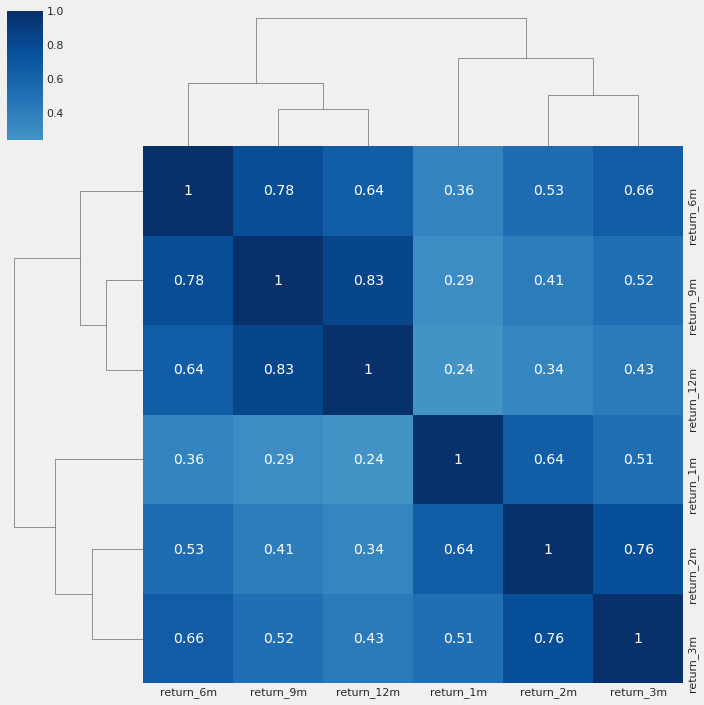

In [24]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data_10.corr('spearman'), annot=True, center=0, cmap='Blues');

We are left with 1,775 tickers.

In [25]:
data_10.index.get_level_values('Sid').nunique()

1140

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 8, Time Series Models]([](../../08_time_series_models)).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [26]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2008')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'Date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2008-01-31 to 2023-03-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  183 non-null    float64
 1   SMB     183 non-null    float64
 2   HML     183 non-null    float64
 3   RMW     183 non-null    float64
 4   CMA     183 non-null    float64
dtypes: float64(5)
memory usage: 8.6 KB


In [27]:
factor_data=factor_data.join(data_10['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 200661 entries, ('FIBBG000B9WP24', Timestamp('2008-01-31 00:00:00', freq='M')) to ('FIBBG00R0TMXH1', Timestamp('2023-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     200661 non-null  float64
 1   SMB        200661 non-null  float64
 2   HML        200661 non-null  float64
 3   RMW        200661 non-null  float64
 4   CMA        200661 non-null  float64
 5   return_1m  200661 non-null  float64
dtypes: float64(6)
memory usage: 10.1+ MB


In [28]:
T = 24
betas = (factor_data
         .groupby(level='Sid', group_keys=False)
         .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), y=x.return_1m, x=x.drop('return_1m', axis=1)).beta))

In [29]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,174441.000000,174441.000000,174441.000000,174441.000000,174441.000000,174441.000000
mean,0.889793,0.452930,0.023415,-0.185519,-0.089573,1.091046
std,0.809745,1.258665,1.341560,1.870208,2.034912,3.303108
min,-3.964067,-12.591699,-17.264664,-25.769509,-16.747135,-37.155779
25%,0.371640,-0.216920,-0.602875,-0.919596,-0.959373,-0.431368
50%,0.841077,0.296622,0.004051,-0.074636,-0.032139,0.910920
75%,1.318142,1.061017,0.643961,0.652555,0.817578,2.642779
max,7.952254,9.505640,13.809221,15.732862,19.182083,29.990175


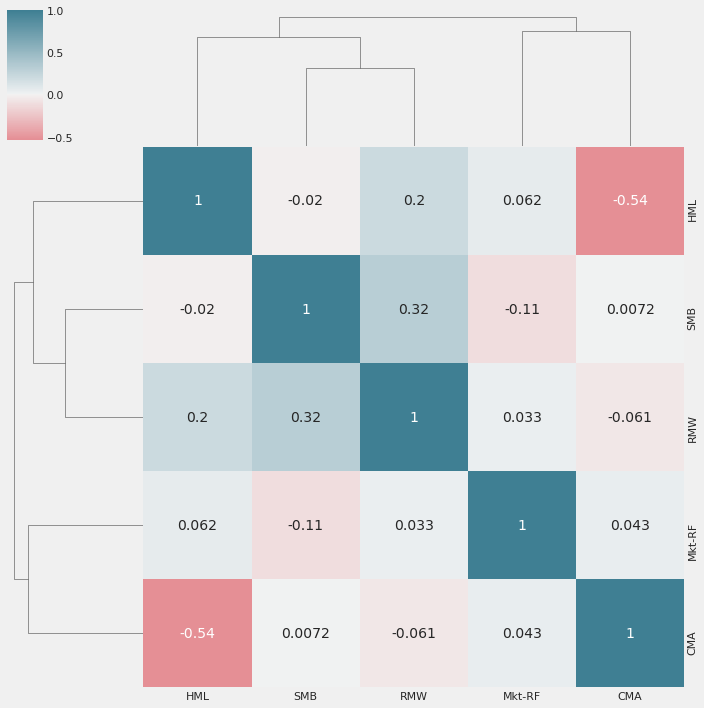

In [30]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [31]:
data_10 = (data_10
        .join(betas
              .groupby(level='Sid')
              .shift()))
data_10.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 200661 entries, ('FIBBG000B9WP24', Timestamp('2008-01-31 00:00:00', freq='M')) to ('FIBBG00R0TMXH1', Timestamp('2023-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   200661 non-null  float64
 1   return_2m   200661 non-null  float64
 2   return_3m   200661 non-null  float64
 3   return_6m   200661 non-null  float64
 4   return_9m   200661 non-null  float64
 5   return_12m  200661 non-null  float64
 6   Mkt-RF      173301 non-null  float64
 7   SMB         173301 non-null  float64
 8   HML         173301 non-null  float64
 9   RMW         173301 non-null  float64
 10  CMA         173301 non-null  float64
dtypes: float64(11)
memory usage: 21.8+ MB


### Impute mean for missing factor betas

In [32]:
data_10.loc[:, factors] = data_10.groupby('Sid')[factors].apply(lambda x: x.fillna(x.mean()))
data_10.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 200661 entries, ('FIBBG000B9WP24', Timestamp('2008-01-31 00:00:00', freq='M')) to ('FIBBG00R0TMXH1', Timestamp('2023-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   200661 non-null  float64
 1   return_2m   200661 non-null  float64
 2   return_3m   200661 non-null  float64
 3   return_6m   200661 non-null  float64
 4   return_9m   200661 non-null  float64
 5   return_12m  200661 non-null  float64
 6   Mkt-RF      200661 non-null  float64
 7   SMB         200661 non-null  float64
 8   HML         200661 non-null  float64
 9   RMW         200661 non-null  float64
 10  CMA         200661 non-null  float64
dtypes: float64(11)
memory usage: 21.8+ MB


## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [33]:
for lag in [2,3,6,9,12]:
    data_10[f'momentum_{lag}'] = data_10[f'return_{lag}m'].sub(data_10.return_1m)
data_10[f'momentum_3_12'] = data_10[f'return_12m'].sub(data_10.return_3m)

## Date Indicators

In [34]:
dates = data_10.index.get_level_values('Date')
data_10['year'] = dates.year
data_10['month'] = dates.month

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [35]:
for t in range(1, 7):
    data_10[f'return_1m_t-{t}'] = data_10.groupby(level='Sid').return_1m.shift(t)
data_10.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 200661 entries, ('FIBBG000B9WP24', Timestamp('2008-01-31 00:00:00', freq='M')) to ('FIBBG00R0TMXH1', Timestamp('2023-03-31 00:00:00', freq='M'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      200661 non-null  float64
 1   return_2m      200661 non-null  float64
 2   return_3m      200661 non-null  float64
 3   return_6m      200661 non-null  float64
 4   return_9m      200661 non-null  float64
 5   return_12m     200661 non-null  float64
 6   Mkt-RF         200661 non-null  float64
 7   SMB            200661 non-null  float64
 8   HML            200661 non-null  float64
 9   RMW            200661 non-null  float64
 10  CMA            200661 non-null  float64
 11  momentum_2     200661 non-null  float64
 12  momentum_3     200661 non-null  float64
 13  momentum_6     200661 non-null  float64
 14  momentum_9     200661 non-null  float64
 15  mo

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [36]:
for t in [1,2,3,6,12]:
    data_10[f'target_{t}m'] = data_10.groupby(level='Sid')[f'return_{t}m'].shift(-t)

In [37]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data_10[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  \
Sid            Date                                                     
FIBBG000B9WP24 2008-04-30  -0.203936  -0.108586  -0.060104   0.001486   
               2008-05-31  -0.001815   0.021281   0.052963  -0.203936   
               2008-06-30   0.044912   0.081468   0.060155  -0.001815   
               2008-07-31   0.119304   0.067860  -0.004408   0.044912   
               2008-08-31   0.018780  -0.061039  -0.078041   0.119304   
               2008-09-30  -0.134603  -0.122944  -0.108853   0.018780   
               2008-10-31  -0.111127  -0.095691  -0.069971  -0.134603   
               2008-11-30  -0.079987  -0.048684  -0.066679  -0.111127   
               2008-12-31  -0.016316  -0.059952  -0.152508  -0.079987   
               2009-01-31  -0.101653  -0.213360  -0.178904  -0.016316   

                           return_2m  return_3m  return_1m_t-1  return_1m_t-2  \
Sid            Date                                                             
FIBBG000B9WP24 2008-04-30  -0.067469  -0.065047      -0.131676      -0.060184   
               2008-05-31  -0.107113  -0.115377       0.001486      -0.131676   
               2008-06-30  -0.108586  -0.073310      -0.203936       0.001486   
               2008-07-31   0.021281  -0.060104      -0.001815      -0.203936   
               2008-08-31   0.081468   0.052963       0.044912      -0.001815   
               2008-09-30   0.067860   0.060155       0.119304       0.044912   
               2008-10-31  -0.061039  -0.004408       0.018780       0.119304   
               2008-11-30  -0.122944  -0.078041      -0.134603       0.018780   
               2008-12-31  -0.095691  -0.108853      -0.111127      -0.134603   
               2009-01-31  -0.048684  -0.069971      -0.079987      -0.111127   

                           return_1m_t-3  
Sid            Date                       
FIBBG000B9WP24 2008-04-30      -0.275864  
               2008-05-31      -0.060184  
               2008-06-30      -0.131676  
               2008-07-31       0.001486  
               2008-08-31      -0.203936  
               2008-09-30      -0.001815  
               2008-10-31       0.044912  
               2008-11-30       0.119304  
               2008-12-31       0.018780  
               2009-01-31      -0.134603

In [38]:
data_10.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 200661 entries, ('FIBBG000B9WP24', Timestamp('2008-01-31 00:00:00', freq='M')) to ('FIBBG00R0TMXH1', Timestamp('2023-03-31 00:00:00', freq='M'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      200661 non-null  float64
 1   return_2m      200661 non-null  float64
 2   return_3m      200661 non-null  float64
 3   return_6m      200661 non-null  float64
 4   return_9m      200661 non-null  float64
 5   return_12m     200661 non-null  float64
 6   Mkt-RF         200661 non-null  float64
 7   SMB            200661 non-null  float64
 8   HML            200661 non-null  float64
 9   RMW            200661 non-null  float64
 10  CMA            200661 non-null  float64
 11  momentum_2     200661 non-null  float64
 12  momentum_3     200661 non-null  float64
 13  momentum_6     200661 non-null  float64
 14  momentum_9     200661 non-null  float64
 15  mo

## Create age proxy

We use quintiles of IPO year as a proxy for company age.

In [39]:
filtered_securities=filtered_securities.reset_index()

In [40]:
data_10 = (data_10
        .join(pd.qcut(metadata.ipo_year, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data_10.age = data_10.age.fillna(-1)

## Create dynamic size proxy

We use the marketcap information from the NASDAQ ticker info to create a size proxy.

Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [41]:
size_factor = (monthly_prices
               .loc[data_10.index.get_level_values('Date').unique(),
                    data_10.index.get_level_values('Sid').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2023-03-31 to 2008-01-31
Columns: 1140 entries, FIBBG000B9WP24 to FIBBG00R0TMXH1
dtypes: float64(1140)
memory usage: 1.6 MB


In [42]:
msize = (size_factor
         .mul(metadata
              .loc[size_factor.columns, 'market_cap'])).dropna(axis=1, how='all')

### Create Size indicator as deciles per period

Compute size deciles per month:

In [46]:
data_10['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data_10.msize = data_10.msize.fillna(-1)

## Combine data

In [47]:
data_10 = data_10.join(metadata[['sector']])
data_10.sector = data_10.sector.fillna('Unknown')

In [48]:
data_10.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 200661 entries, ('FIBBG000B9WP24', Timestamp('2008-01-31 00:00:00', freq='M')) to ('FIBBG00R0TMXH1', Timestamp('2023-03-31 00:00:00', freq='M'))
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      200661 non-null  float64
 1   return_2m      200661 non-null  float64
 2   return_3m      200661 non-null  float64
 3   return_6m      200661 non-null  float64
 4   return_9m      200661 non-null  float64
 5   return_12m     200661 non-null  float64
 6   Mkt-RF         200661 non-null  float64
 7   SMB            200661 non-null  float64
 8   HML            200661 non-null  float64
 9   RMW            200661 non-null  float64
 10  CMA            200661 non-null  float64
 11  momentum_2     200661 non-null  float64
 12  momentum_3     200661 non-null  float64
 13  momentum_6     200661 non-null  float64
 14  momentum_9     200661 non-null  float64
 15  mo

In [49]:
data_10

return_1m  return_2m  return_3m  return_6m  \
Sid            Date                                                     
FIBBG000B9WP24 2008-01-31  -0.275864  -0.043945   0.045514  -0.020303   
               2008-02-29  -0.060184  -0.175043  -0.049389   0.019634   
               2008-03-31  -0.131676  -0.096637  -0.160833  -0.001452   
               2008-04-30   0.001486  -0.067469  -0.065047  -0.011311   
               2008-05-31  -0.203936  -0.107113  -0.115377  -0.082976   
...                              ...        ...        ...        ...   
FIBBG00R0TMXH1 2022-11-30   0.271048   0.099428  -0.041288  -0.062489   
               2022-12-31  -0.066914   0.089035   0.040922  -0.055534   
               2023-01-31   0.183991   0.051078   0.119809  -0.033839   
               2023-02-28   0.074335   0.127831   0.058774   0.007501   
               2023-03-31   0.247722   0.157787   0.166457   0.101903   

                           return_9m  return_12m    Mkt-RF       SMB  \
Sid            Date                                                    
FIBBG000B9WP24 2008-01-31   0.023341    0.048380  0.386294  1.076329   
               2008-02-29  -0.002853    0.009590  0.386294  1.076329   
               2008-03-31  -0.012763   -0.008671  0.386294  1.076329   
               2008-04-30  -0.035451    0.000490  0.386294  1.076329   
               2008-05-31  -0.027516   -0.032259  0.386294  1.076329   
...                              ...         ...       ...       ...   
FIBBG00R0TMXH1 2022-11-30  -0.080522   -0.077429  1.298471  0.687217   
               2022-12-31  -0.088531   -0.076349  1.352327  0.394186   
               2023-01-31  -0.047195   -0.058306  1.345742  0.567264   
               2023-02-28  -0.023696   -0.047518  1.424238  0.682843   
               2023-03-31   0.013321   -0.030554  1.323342  0.491777   

                                HML       RMW  ...  return_1m_t-5  \
Sid            Date                            ...                  
FIBBG000B9WP24 2008-01-31 -0.242337 -0.832003  ...            NaN   
               2008-02-29 -0.242337 -0.832003  ...            NaN   
               2008-03-31 -0.242337 -0.832003  ...            NaN   
               2008-04-30 -0.242337 -0.832003  ...            NaN   
               2008-05-31 -0.242337 -0.832003  ...            NaN   
...                             ...       ...  ...            ...   
FIBBG00R0TMXH1 2022-11-30  0.064534 -0.271027  ...      -0.107389   
               2022-12-31 -0.242316  0.246626  ...       0.033162   
               2023-01-31 -0.368810  0.240338  ...      -0.164469   
               2023-02-28 -0.367218  0.181245  ...      -0.270995   
               2023-03-31 -0.706255  0.219308  ...      -0.049020   

                           return_1m_t-6  target_1m  target_2m  target_3m  \
Sid            Date                                                         
FIBBG000B9WP24 2008-01-31            NaN  -0.060184  -0.096637  -0.065047   
               2008-02-29            NaN  -0.131676  -0.067469  -0.115377   
               2008-03-31            NaN   0.001486  -0.107113  -0.073310   
               2008-04-30            NaN  -0.203936  -0.108586  -0.060104   
               2008-05-31            NaN  -0.001815   0.021281   0.052963   
...                                  ...        ...        ...        ...   
FIBBG00R0TMXH1 2022-11-30      -0.137201  -0.066914   0.051078   0.058774   
               2022-12-31      -0.107389   0.183991   0.127831   0.166457   
               2023-01-31       0.033162   0.074335   0.157787        NaN   
               2023-02-28      -0.164469   0.247722        NaN        NaN   
               2023-03-31      -0.270995        NaN        NaN        NaN   

                           target_6m  target_12m  age  msize  \
Sid            Date                                            
FIBBG000B9WP24 2008-01-31  -0.062579   -0.050245    1      2   
               2008-02-29  -0.034871   -0.053810

## Store data

We will use the data again in several later chapters, starting in [Chapter 6 on Linear Models](../../06_machine_learning_process/02_mutual_information/mutual_information.ipynb).

In [52]:

with pd.HDFStore('model_data.h5') as store:
    store.put('monthly/engineered_features', data_10)
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: model_data.h5
/monthly/engineered_features            frame        (shape->[200661,33])


## Create Dummy variables

For most models, we need to encode categorical variables as 'dummies' (one-hot encoding):

In [ ]:
# dummy_data = pd.get_dummies(data,
#                             columns=['year','month', 'msize', 'age',  'sector'],
#                             prefix=['year','month', 'msize', 'age', ''],
#                             prefix_sep=['_', '_', '_', '_', ''])
# dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
# dummy_data.info()